# Paralelni algoritmi - drugi projekat

- Projekat se radi individualno ili u paru

- Rok za predaju projekata je ponedeljak 14.12.2020. Biće potrebno da se studenti koji planiraju da urade i odbrane projekat prijave, do datuma i procedurom koji će naknadno biti objavljeni.

- Predaja projekata je putem emaila, programski kod bi trebalo da
bude prikacen uz sam email. Link ka Collab-u je opcion. Ukoliko dva
studenta rade u paru, dovoljno je da jedan od njih preda, pri cemu
drugog stavi u cc. E-mail treba da sadrzi sve podatke (ime, prezime,
broj indeksa) za oba studenta.


1. **Pristup tekstu sa Wikipedije putem MapReduce programa (6 bodova)**  
Napisati program koji kroz map-reduce paradigmu (upotrebom funkcije *map* iz Python standardne biblioteke i funkcije *reduce* iz paketa *functools*):
  - Za zadatu listu ključnih reči vrši pretragu Wiki stranica i dohvata zadati broj rezultata (naslova stranica)
    Za pristup wiki stranicama se može koristiti python biblioteku [*wikipedia*](https://pypi.org/project/wikipedia/):
```python
import wikipedia
wikipedia.set_lang("sr")
```
```python
def get_pages(query, results=50):
  '''Dohvata naslove zahtevanog broja stranica koje se pojavaljuju kao 
      rezultati pretrage za zadatu kljucnu rec'''
      pages = wikipedia.search(query, results=results)
      return pages
```
  - Paralelizovati rešenje iz prethodne tačke upotrebom funkcija `Pool.map` iz paketa `multiprocessing`
  - Wikipedia API ponekad vrati nevalidne naslove stranica, pa je rezultate neophodno sanitizovati. Napisati map/reduce rešenje koje sanitizuje rezultate iz prethodne tačke. Sanitizacija se može izvesti pokušajem da dohvatanja stranice na osnovu nasova (`wikipedia.page(title)`) i hvatanjem izuzetaka.
  - Napisati map/reduce rešenje koje dohvata sažetke stranica (`page.summary`) iz sanitizovane liste formirane u prethodnoj tački.
  - Wikipedia API ponekad meša stranice na ćiriličnom i latiničnom pismu. Unifikovati tekstive dobijene u prethodnoj tački prevođenjem reči na isto pismo (ćirilično ili latinično)
  ```python
import transliterate
transliterate.translit(word, 'sr')
```
 - Odabrati nekoliko ključnih reči po slobodnom izboru i pokazati da program radi dohvatanjem po dva rezultata za svaku kljunu reč.

2. **Brojanje reci u tesktu i bag-of-words reprezentacija putem MapReduce programa (8 bodova)**  
U ovom zadatku ćemo stranice predstaviti kao *bag-of-words* vektore. *Bag-of-words* reprezentacija se dobija tako što za *sve** reči koje se pojavljuju u svim tekstovima izbrojimo koliko puta se pojavljuju u svakom tekstu. Tekst potom predstvaljamo kao vektor ovih brojeva.   
Na primer, posmatrajmo dva teksta:
``` 
Pera voli da gleda filmove. Mika takođe voli filmove.
``` 
```
Mika voli da gleda i fudbalske utakmice.
```
Reči koje se pojavljuju su:
```
Pera, voli, da, gleda, filmove, Mika, takođe, i, fudbalske, utakmice
``` 
  *Bag-of-words* reprezentacija tekstova je:
```
1, 2, 1, 1, 2, 1, 1, 0, 0, 0
```
odnosno:
```
0, 1, 1, 1, 0, 1, 0, 1, 1, 1
```
U praksi se reči koje se previše često ili previše retko pojavljuju uglavnom odbacuju. 
  - Napisati map/reduce program koji datu listu tesktiva pretvara u *Bag-of-words* reprezentaciju. Pre brojanja reči potrebno je sve reči prevesti u mala ili velika slova (po vašem izboru), te izbaciti interpunkcijske znake i specijalne karaktere (u najmanju ruku sledeći skup `\n, \t, =, -, (, ), _`). Odbaciti reči koje se pojavljuju veoma često u većini tekstovima (nalaze se u 90% najčešćih reči u bar 90% tekstova), ili se pojavljuju u manje od 1% tekstova. Ovu obradu izvesti kroz posebne map/reduce korake.
  - Ručno uneti nekoliko tekstova po slobodnom izboru i pokazati da program radi.

3. **K-means klastersanje putem MapReduce programa (5 bodova)**   
Napisati map/reduce program koji vrši k-means klasterisanje liste vektora.
Nasumično generisati podatke iz nekoliko normalnih raspodela u dve dimenzije i pokazati da algoritam radi (videti vežbe za primer). 

4. **Primena rešenja  (6 bodova)**  
Povezati kod iz zadataka 1-3 kojim se Wiki na srpskom jeziku pretražuje za sledeći skup ključnih reči `['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']`, za svaku dohvata po 50 rezultata, stranice prevode u *bag-of-words* reprezentaciju, i vrši njihovo klasterisanje. 
U kojom meri klasteri odgovaraju temama prema kojima su stranice dohvatane?

In [1]:
!pip install wikipedia
!pip install transliterate

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=3dfb506281e0e65e6bcd35b766580838441e7b4d4c6eb2c83f361d1f33a638f6
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
     |████████████████████████████████| 51kB 4.2MB/s 


In [15]:
# ***************************** PRVA TACKA *******************************
import multiprocessing as mp
import wikipedia
import transliterate
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import starmap

wikipedia.set_lang("sr")

pool = mp.Pool(mp.cpu_count())


def get_pages(kljucnaRec):
    pages = wikipedia.search(kljucnaRec, results = 2)
    return pages

def napraviSazetak(akumulator, naslov):
    try:
        sazetak = wikipedia.summary(naslov, sentences=1)
        return akumulator + [sazetak]
    except:
        return akumulator + [None]

def reduceSazetaka(akumulator, sazetak): 
    if sazetak is not None:
        return akumulator + [transliterate.translit(sazetak, 'sr')]
    else:
        return akumulator

kljucneReci = ['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']

listeNaslova = pool.map(get_pages, kljucneReci)
listeSazetaka = [reduce(napraviSazetak, nizNaslova, []) for nizNaslova in listeNaslova]
prevedeniSazeci = [reduce(reduceSazetaka, nizSazetaka, []) for nizSazetaka in listeSazetaka]

for n in prevedeniSazeci:
    print(n)


['Градска општина Нови Београд је градска општина, уједно и насељено место, града Београда и простире се на површини од 4.096 хектара.', 'Београд 2020 је пројекат кандидатуре града Београда за Европску престоницу културе 2020.']
['Блискоисточни театар Првог светског рата обухвата ратна дејства између 29.', 'Румунски поход (Први светски рат) представљао је сукоб Румуније (односно њене војске) и Русије против Централних сила током Првог светског рата.']
['Протеин–протеин интеракције се јављају кад се два или више протеина вежу, често да би вршили своју биолошку функцију.', 'Г протеини (гуанин нуклеотид везујући протеини) су фамилија протеина каја учествује у преносу хемијских сигнала изван ћелије, и узрокује промене унутар ћелије.']
['Микропроцесор је интегрисано коло великог степена интеграције компонената.', 'Интел 80186 је микропроцесор развијен у Интелу 1982 године.']
['ОШ „Стефан Немања” је државна установа основног образовања, која је почела са радом 1838.', 'ОШ „Стефан Немања” јед

In [22]:
# ***************************** DRUGA TACKA *******************************
import multiprocessing as mp
import wikipedia
import transliterate
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import starmap

wikipedia.set_lang("sr")

pool = mp.Pool(mp.cpu_count())


# test1 = "Pera (voli) (da gleda) filmove. Mika takođe voli filmove. i "
# test2 = "Mika voli da da gleda i fudbalske utakmice. i "
# test3 = "Mika voli da pije caj i da se kocka. i "
# test4 = "Zika voli da da kupuje banane i pomorandze. i "
# test5 = "Pera stvarno voli da izadje u hleb sumu i da se klacka. i "
# test6 = "Zika voli da da pliva kraul i prsno. i "
# test7 = "Pera voli da da gleda golubove i vrapce. i "
# test8 = "Mika ne voli da da kupuje suv i bajat hleb hleb hleb hleb. i "
# test9 = "Mika voli da da gleda i fudbalske utakmice. i "
# test10 = "Pera je krenuo da da peca ribe i slonove. i "

test1 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda voda"
test2 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda voda voda"
test3 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda"
test4 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen cep cep cep cepcep cep cep cep"
test5 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda voda bure"
test6 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen cep cep cep cepcep cep "
test7 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda voda bure baruta"
test8 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen cep cep cep cepcep cep cep detelina"
test9 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen voda voda voda voda voda voda voda voda detelina"
test10 = "bagrem bagrem bagrem voli voli voli voli voli patike i i i i i i i i i majica majica kamen flasa kamen flasa kamen cep cep cep cepcep cep cep detelina detelina"
testovi = [test1, test2, test3, test4, test5, test6, test7, test8, test9, test10]

def znakovi(rec):
    novaRec = rec
    if rec[-1] == "\n" or rec[-1] == "\t" or rec[-1] == "." or rec[-1] == "," or rec[-1] == "!" or rec[-1] == "?" or rec[-1] == "=" or rec[-1] == "-" or  rec[-1] == ")" or rec[-1] == "_":
        novaRec = novaRec[:-1]
    if rec[0] == "(":
        novaRec = novaRec[1:]
    return str.lower(novaRec)


def izbaciDuplikate(akumulator, rec):
    if rec in akumulator:
        return akumulator
    return akumulator + [rec]


def mapiranjeTaplova(tapl):
    return (tapl, 1)


def reduceTaplova(akumulator, tapl):
    if akumulator and akumulator[-1][0] == tapl[0]:
        akumulator[-1] = akumulator[-1][0], akumulator[-1][1] + tapl[1]
    else:
        akumulator.append(tapl)
    return akumulator


def mapiranjeReci(rec):
    return (rec, 1)


def reduceReci(akumulator, rec):
    if akumulator and akumulator[-1][0] == rec[0]:
        akumulator[-1] = akumulator[-1][0], akumulator[-1][1] + rec[1]
    else:
        akumulator.append(rec)
    return akumulator


def reciZaIzbacivanje(akumulator, tapl):
    if tapl[1] < round(len(sredjeniTestovi) * 0.9, 0):
        return akumulator
    return akumulator + [tapl[0]]

def izbrojRetke(akumulator, velikiTapl):
    if akumulator and akumulator[-1][0] == velikiTapl[0][1]:
        akumulator[-1] = (akumulator[-1][0], akumulator[-1][1] + 1)
    else:
        akumulator.append((velikiTapl[0][1], 1))
    return akumulator

def izbrojRetkeReci(akumulator, tapl):
    if tapl[1] <= round((len(testovi) * 1/100), 0):
        return akumulator + [tapl[0]]
    return akumulator


sredjeniTestovi = [pool.map(znakovi, test.split()) for test in testovi]
print("sredjeniTestovi ----> ", sredjeniTestovi, "\n")

indexTestaIRec = [(sredjeniTestovi.index(test), rec) for test in sredjeniTestovi for rec in test]
print("indexTestaIRec ----> ", indexTestaIRec, "\n")

velikiTaplovi = pool.map(mapiranjeTaplova, indexTestaIRec)
print("velikiTaplovi ----> ", velikiTaplovi, "\n")

sortiraniVelikiTaplovi = sorted(velikiTaplovi, key=lambda x: x[0][1])
print("sortiraniVelikiTaplovi ----> ", sortiraniVelikiTaplovi, "\n")

izbrojaniVelikiTaplovi = reduce(reduceTaplova, sortiraniVelikiTaplovi, [])
print("izbrojaniVelikiTaplovi ----> ", izbrojaniVelikiTaplovi, "\n")

najredjeReciSortirane = sorted(izbrojaniVelikiTaplovi, key=lambda x: x[0][1])
print("najredjeReciSortirane ----> ", najredjeReciSortirane, "\n")

najredjeReci = reduce(izbrojRetke, najredjeReciSortirane, [])
print("najredjeReci ----> ", najredjeReci, "\n")

retkeReciZaIzbacivanje = reduce(izbrojRetkeReci, najredjeReci, [])
print("retkeReciZaIzbacivanje ----> ", retkeReciZaIzbacivanje, "\n")


cesteReci = []
for test in sredjeniTestovi:
    brojNajcescihReci = round(len(test) * 0.9, 0)
    taploviZaReci = pool.map(mapiranjeReci, test)
    sortiraniTaploviZaReci = sorted(taploviZaReci, key=lambda x: x[0])
    izbrojaniTaplovi = reduce(reduceReci, sortiraniTaploviZaReci, [])
    sortiraniTaploviZaReci = sorted(izbrojaniTaplovi, key=lambda x: x[1])
    sortiraniTaploviZaReci = list(reversed(sortiraniTaploviZaReci))
    brojac = 0
    i = 0
    while brojac < brojNajcescihReci:
        tapl = sortiraniTaploviZaReci[i]
        cesteReci.append(tapl[0])
        brojac += tapl[1]
        i += 1

print("cesteReci ----> ", cesteReci, "\n")

taploviZaCesteReci = pool.map(mapiranjeReci, cesteReci)
print("taploviZaCesteReci ----> ", taploviZaCesteReci, "\n")

sortiraniTaploviZaCesteReci = sorted(taploviZaCesteReci, key=lambda x: x[0])
print("sortiraniTaploviZaCesteReci ----> ", sortiraniTaploviZaCesteReci, "\n")

izbrojaneCesteReci = reduce(reduceReci, sortiraniTaploviZaCesteReci, [])
print("izbrojaneCesteReci ----> ", izbrojaneCesteReci, "\n")

cesteReciZaIzbacivanje = reduce(reciZaIzbacivanje, izbrojaneCesteReci, [])
print("cesteReciZaIzbacivanje ----> ", cesteReciZaIzbacivanje, "\n")

reci = pool.map(znakovi, [rec for string in testovi for rec in string.split()])
reci = reduce(izbaciDuplikate, reci, [])
print("reci ----> ", reci, "\n")

reci = [rec for rec in reci if rec not in cesteReciZaIzbacivanje]
reci = [rec for rec in reci if rec not in retkeReciZaIzbacivanje]

print("reci nakon izbacivanja ----> ", reci, "\n")

# vektori = [[0] * len(reci) for i in range(0, len(testovi))]
vektori = np.zeros((len(testovi), len(reci)))
print(vektori)

for tapl in izbrojaniVelikiTaplovi:
    (unutrasnji, ponavljanje) = tapl
    (brojTesta, rec) = unutrasnji
    if rec in reci:
        indexReci = reci.index(rec)
        vektori[brojTesta][indexReci] = ponavljanje

for vektor in vektori:
    print(vektor)


sredjeniTestovi ---->  [['bagrem', 'bagrem', 'bagrem', 'voli', 'voli', 'voli', 'voli', 'voli', 'patike', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'majica', 'majica', 'kamen', 'flasa', 'kamen', 'flasa', 'kamen', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda'], ['bagrem', 'bagrem', 'bagrem', 'voli', 'voli', 'voli', 'voli', 'voli', 'patike', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'majica', 'majica', 'kamen', 'flasa', 'kamen', 'flasa', 'kamen', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda'], ['bagrem', 'bagrem', 'bagrem', 'voli', 'voli', 'voli', 'voli', 'voli', 'patike', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'majica', 'majica', 'kamen', 'flasa', 'kamen', 'flasa', 'kamen', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda', 'voda'], ['bagrem', 'bagrem', 'bagrem', 'voli', 'voli', 'voli', 'voli', 'voli', 'patike', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'majica', 'majica', 'kamen', 'flasa', 'kamen', 'flasa', 'kamen', 'cep', 'cep', 'ce

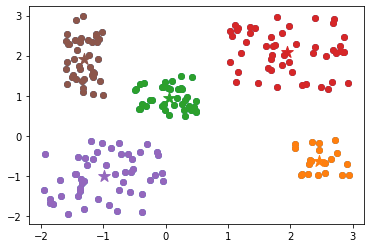

In [18]:
# ***************************** TRECA TACKA *******************************
import multiprocessing as mp
import wikipedia
import transliterate
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import starmap

wikipedia.set_lang("sr")

pool = mp.Pool(mp.cpu_count())


data = -2 * np.random.rand(200, 2)

data1 = 1 + 2 * np.random.rand(50, 2)
data2 = 0.5 + np.random.rand(40, 2)
data2[:, 0] = data2[:, 0] - 1

data3 = 0.5 + np.random.rand(40, 2)
data3[:, 0] = (data3[:, 0] - 3)/1.5
data3[:, 1] = data3[:, 1] * 2

data4 = np.random.rand(20, 2)
data4[:, 0] = data4[:, 0] +2
data4[:, 1] = data4[:, 1]-1

data[50:100, :] = data1
data[100:140, :] = data2
data[140:180, :] = data3
data[180:200, :] = data4

k = 5
np.random.seed(3)
centroids = np.random.uniform(-2, 3, (k, 2))

class Klasterovanje():
    
    def __init__(self, brojIteracija, podaci, centroide):
        super().__init__()
        self.brojIteracija = brojIteracija
        self.podaci = podaci
        self.centroide = centroide
        self.grupeTacaka = np.zeros(self.podaci.shape[0], dtype=np.int8)

    def obrada(self):
        for _ in range(self.brojIteracija):
            self.grupeTacaka = np.zeros(self.podaci.shape[0], dtype=np.int8)
            self.grupeTacaka = reduce(self.indeksiranje, self.grupeTacaka, [])
            self.grupeTacaka = pool.map(self.odrediGrupe, self.grupeTacaka)
            self.centroide = pool.map(self.izmeniKoordinate, enumerate(self.centroide))

            # self.crtanje()
        
    def izmeniKoordinate(self, tapl):
        (index, controida) = tapl
        cluster = [podatak for j, podatak in enumerate(self.podaci) if self.grupeTacaka[j][1] == index]
        x = sum(x[0] for x in cluster)/len(cluster)
        y = sum(x[1] for x in cluster)/len(cluster)
        return [x, y]

    def odrediGrupe(self, tapl):
        (index, grupa) = tapl
        distance = np.sqrt(((self.centroide - self.podaci[index])**2).sum(axis=1))
        return (index, np.argmin(distance))

    @staticmethod
    def indeksiranje(akumulator, broj):
      if not akumulator:
        return [(0, broj)]
      else: 
        return akumulator + [(akumulator[-1][0]+1, broj)]

    def crtanje(self):
        plt.scatter(self.podaci[ : , 0], self.podaci[ :, 1])
        for i, c in enumerate(self.centroide):
            plot = plt.scatter(*c, marker='*', s=150)
            cluster = [podatak for j, podatak in enumerate(self.podaci) if self.grupeTacaka[j][1] == i]
            cluster = np.array(cluster)
            plt.scatter(cluster[:, 0], cluster[:, 1], c=plot.get_facecolor())


klasterovanje = Klasterovanje(50, data, centroids)
klasterovanje.obrada()
klasterovanje.crtanje()




In [32]:
# ***************************** CETVRTA TACKA *******************************
import multiprocessing as mp
import wikipedia
import transliterate
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import starmap

wikipedia.set_lang("sr")

pool = mp.Pool(mp.cpu_count())


def get_pages(kljucnaRec):
    pages = wikipedia.search(kljucnaRec, results = 5)
    return pages

def napraviSazetak(akumulator, naslov):
    try:
        sazetak = wikipedia.summary(naslov, sentences=1)
        return akumulator + [sazetak]
    except:
        return akumulator + [None]

def reduceSazetaka(akumulator, sazetak): 
    if sazetak is not None:
        return akumulator + [transliterate.translit(sazetak, 'sr')]
    else:
        return akumulator

kljucneReci = ['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']

listeNaslova = pool.map(get_pages, kljucneReci)
listeSazetaka = [reduce(napraviSazetak, nizNaslova, []) for nizNaslova in listeNaslova]
prevedeniSazeci = [reduce(reduceSazetaka, nizSazetaka, []) for nizSazetaka in listeSazetaka]

for n in prevedeniSazeci:
    print(n)
print("\n")

testovi = [test for naslov in prevedeniSazeci for test in naslov]

def znakovi(rec):
    novaRec = rec
    if rec[-1] == "\n" or rec[-1] == "\t" or rec[-1] == "." or rec[-1] == "," or rec[-1] == "!" or rec[-1] == "?" or rec[-1] == "=" or rec[-1] == "-" or  rec[-1] == ")" or rec[-1] == "_":
        novaRec = novaRec[:-1]
    if rec[0] == "(":
        novaRec = novaRec[1:]
    return str.lower(novaRec)


def izbaciDuplikate(akumulator, rec):
    if rec in akumulator:
        return akumulator
    return akumulator + [rec]


def mapiranjeTaplova(tapl):
    return (tapl, 1)


def reduceTaplova(akumulator, tapl):
    if akumulator and akumulator[-1][0] == tapl[0]:
        akumulator[-1] = akumulator[-1][0], akumulator[-1][1] + tapl[1]
    else:
        akumulator.append(tapl)
    return akumulator


def mapiranjeReci(rec):
    return (rec, 1)


def reduceReci(akumulator, rec):
    if akumulator and akumulator[-1][0] == rec[0]:
        akumulator[-1] = akumulator[-1][0], akumulator[-1][1] + rec[1]
    else:
        akumulator.append(rec)
    return akumulator


def reciZaIzbacivanje(akumulator, tapl):
    if tapl[1] < round(len(sredjeniTestovi) * 0.9, 0):
        return akumulator
    return akumulator + [tapl[0]]

def izbrojRetke(akumulator, velikiTapl):
    if akumulator and akumulator[-1][0] == velikiTapl[0][1]:
        akumulator[-1] = (akumulator[-1][0], akumulator[-1][1] + 1)
    else:
        akumulator.append((velikiTapl[0][1], 1))
    return akumulator

def izbrojRetkeReci(akumulator, tapl):
    if tapl[1] <= round((len(testovi) * 1/100), 0):
        return akumulator + [tapl[0]]
    return akumulator


sredjeniTestovi = [pool.map(znakovi, test.split()) for test in testovi]
# print("sredjeniTestovi ----> ", sredjeniTestovi, "\n")

indexTestaIRec = [(sredjeniTestovi.index(test), rec) for test in sredjeniTestovi for rec in test]
# print("indexTestaIRec ----> ", indexTestaIRec, "\n")

velikiTaplovi = pool.map(mapiranjeTaplova, indexTestaIRec)
# print("velikiTaplovi ----> ", velikiTaplovi, "\n")

sortiraniVelikiTaplovi = sorted(velikiTaplovi, key=lambda x: x[0][1])

izbrojaniVelikiTaplovi = reduce(reduceTaplova, sortiraniVelikiTaplovi, [])

najredjeReciSortirane = sorted(izbrojaniVelikiTaplovi, key=lambda x: x[0][1])

najredjeReci = reduce(izbrojRetke, najredjeReciSortirane, [])

retkeReciZaIzbacivanje = reduce(izbrojRetkeReci, najredjeReci, [])


cesteReci = []
for test in sredjeniTestovi:
    brojNajcescihReci = round(len(test) * 0.9, 0)
    taploviZaReci = pool.map(mapiranjeReci, test)
    sortiraniTaploviZaReci = sorted(taploviZaReci, key=lambda x: x[0])
    izbrojaniTaplovi = reduce(reduceReci, sortiraniTaploviZaReci, [])
    sortiraniTaploviZaReci = sorted(izbrojaniTaplovi, key=lambda x: x[1])
    sortiraniTaploviZaReci = list(reversed(sortiraniTaploviZaReci))
    brojac = 0
    i = 0
    while brojac < brojNajcescihReci:
        tapl = sortiraniTaploviZaReci[i]
        cesteReci.append(tapl[0])
        brojac += tapl[1]
        i += 1

taploviZaCesteReci = pool.map(mapiranjeReci, cesteReci)

sortiraniTaploviZaCesteReci = sorted(taploviZaCesteReci, key=lambda x: x[0])

izbrojaneCesteReci = reduce(reduceReci, sortiraniTaploviZaCesteReci, [])

cesteReciZaIzbacivanje = reduce(reciZaIzbacivanje, izbrojaneCesteReci, [])

reci = pool.map(znakovi, [rec for string in testovi for rec in string.split()])
reci = reduce(izbaciDuplikate, reci, [])

reci = [rec for rec in reci if rec not in cesteReciZaIzbacivanje]
reci = [rec for rec in reci if rec not in retkeReciZaIzbacivanje]


vektori = np.zeros((len(testovi), len(reci)))

for tapl in izbrojaniVelikiTaplovi:
    (unutrasnji, ponavljanje) = tapl
    (brojTesta, rec) = unutrasnji
    if rec in reci:
        indexReci = reci.index(rec)
        vektori[brojTesta][indexReci] = ponavljanje

k = 15
centroids = np.random.uniform(-2, 3, (k, len(reci)))
print(centroids)

class Klasterovanje():
    
    def __init__(self, brojIteracija, vektori, centroide):
        super().__init__()
        self.brojIteracija = brojIteracija
        self.vektori = vektori
        self.centroide = centroide
        self.grupeTacaka = np.zeros(self.vektori.shape[0], dtype=np.int8)

    def obrada(self):
        for _ in range(self.brojIteracija):
            self.grupeTacaka = np.zeros(self.vektori.shape[0], dtype=np.int8)
            self.grupeTacaka = reduce(self.indeksiranje, self.grupeTacaka, [])
            self.grupeTacaka = pool.map(self.odrediGrupe, self.grupeTacaka)
            self.centroide = pool.map(self.izmeniKoordinate, enumerate(self.centroide))
        
    def izmeniKoordinate(self, tapl):
        (index, centroida) = tapl
        cluster = [podatak for j, podatak in enumerate(self.vektori) if self.grupeTacaka[j][1] == index]

        if len(cluster) > 0:
            novaCentroida = []
            for i, vrednost in enumerate(centroida):
                novaCentroida.append(sum(x[i] for x in cluster)/len(cluster))
            nova = np.array(novaCentroida)
            return nova

        return centroida

    def odrediGrupe(self, tapl):
        (index, grupa) = tapl
        distance = np.sqrt(((self.centroide - self.vektori[index])**2).sum(axis=1))
        return (index, np.argmin(distance))

    @staticmethod
    def indeksiranje(akumulator, broj):
      if not akumulator:
        return [(0, broj)]
      else: 
        return akumulator + [(akumulator[-1][0]+1, broj)]


klasterovanje = Klasterovanje(50, vektori, centroids)
klasterovanje.obrada()

['Градска општина Нови Београд је градска општина, уједно и насељено место, града Београда и простире се на површини од 4.096 хектара.', 'Београд 2020 је пројекат кандидатуре града Београда за Европску престоницу културе 2020.', 'Градско саобраћајно предузеће „Београд“ (ГСП „Београд“) је јавно комунално предузеће у Београду коме је основна делатност превоз путника у градском и приградском саобраћају.', 'Блуе драгонс (енгл.', 'ОФК Београд је српски фудбалски клуб из Београда.']
['Блискоисточни театар Првог светског рата обухвата ратна дејства између 29.', 'Румунски поход (Први светски рат) представљао је сукоб Румуније (односно њене војске) и Русије против Централних сила током Првог светског рата.', 'Ово је списак земаља које су учествовале у Првом светском рату, по абецедном реду.', 'Балканско ратиште у Првом светском рату обухвата војна дејства која су током Првог светског рата вођена на подручју Балканског полуострва између снага Антанте са једне и Централних сила са друге стране.',